In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q efficientnet

In [3]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from scipy import stats
import cv2
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.utils import to_categorical
from keras.layers import Dense
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.applications.xception import Xception
import tensorflow as tf
import tensorflow.keras.layers as L

import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
print(os.listdir('../input/landmark-recognition-2020/'))

['sample_submission.csv', 'train.csv', 'test', 'train']


In [5]:
train_df = pd.read_csv('../input/landmark-recognition-2020/train.csv')
sample_df = pd.read_csv('../input/landmark-recognition-2020/sample_submission.csv')

In [6]:
landmark_count=pd.value_counts(train_df["landmark_id"])
landmark_count=landmark_count.reset_index()
landmark_count.rename(columns={"index":'landmark_id','landmark_id':'count'},inplace=True)
landmark_count

,landmark_id,count
0,138982,6272
1,126637,2231
2,20409,1758
3,83144,1741
4,113209,1135
...,...,...
81308,84677,2
81309,36989,2
81310,133688,2
81311,17316,2


In [7]:
train_df.shape

(1580470, 2)

In [8]:
train_df.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580470 entries, 0 to 1580469
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1580470 non-null  object
 1   landmark_id  1580470 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.1+ MB


In [10]:
landmarks = len(train_df['landmark_id'].unique())
landmarks

81313

In [11]:
landmark_count = train_df.landmark_id.value_counts().head(10).to_frame() # to_frame converts data in to dataframe.
landmark_count = landmark_count.reset_index() 
landmark_count.rename(columns={"index":'landmark_id','landmark_id':'count'},inplace=True)
landmark_count.style.background_gradient(cmap='Oranges')

,landmark_id,count
0,138982,6272
1,126637,2231
2,20409,1758
3,83144,1741
4,113209,1135
5,177870,1088
6,194914,1073
7,149980,971
8,139894,966
9,1924,944


<Figure size 1000x800 with 0 Axes>

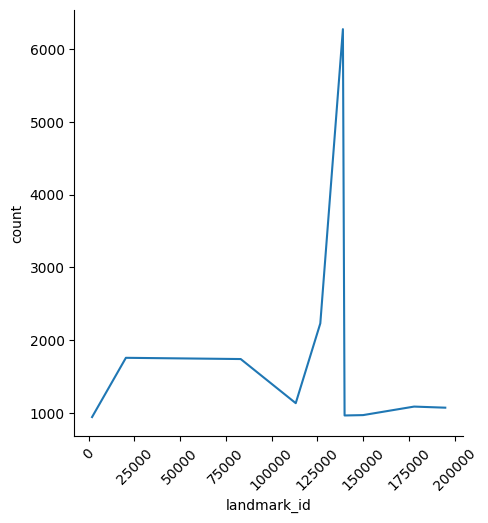

In [12]:
plt.figure(figsize=(10,8))
sns.relplot(data=landmark_count, x='landmark_id', y='count',kind='line')
plt.xticks(rotation=45)
plt.show()

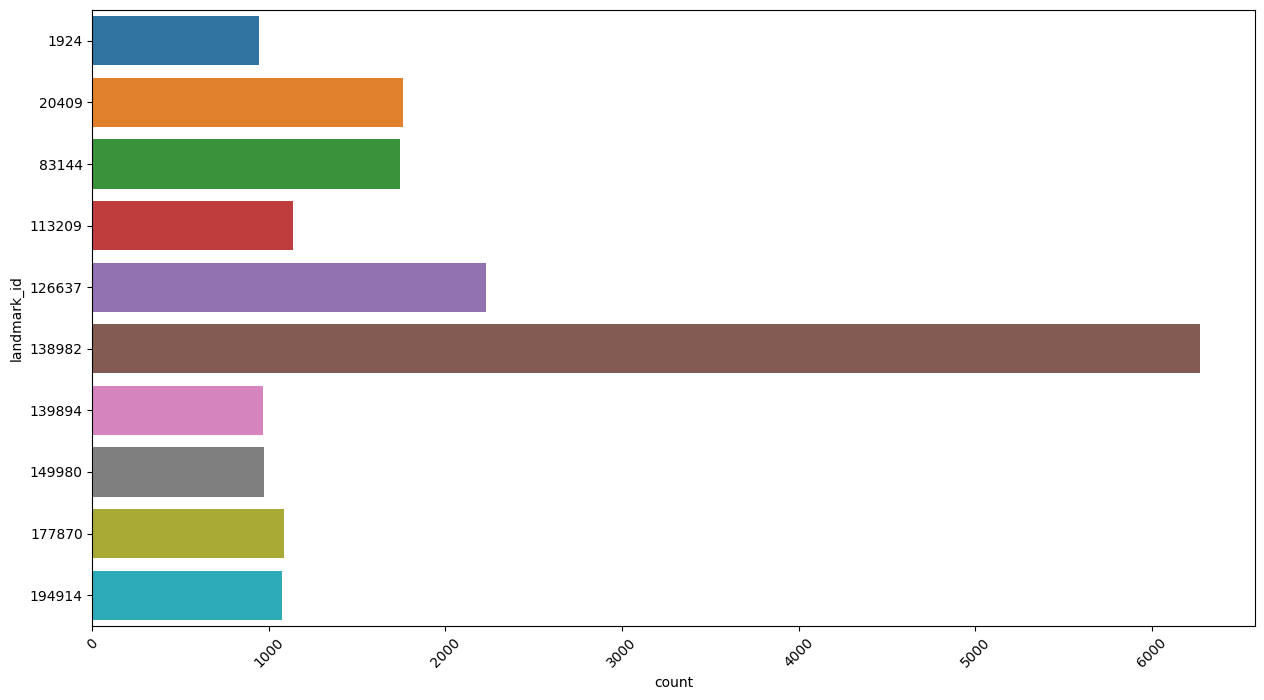

In [13]:
plt.figure(figsize=(15,8))
sns.barplot(data=landmark_count, y='landmark_id', x='count',orient='h')
sns.set_color_codes("pastel")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_24/2094620581.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['landmark_id'], color="tomato", shade=True)


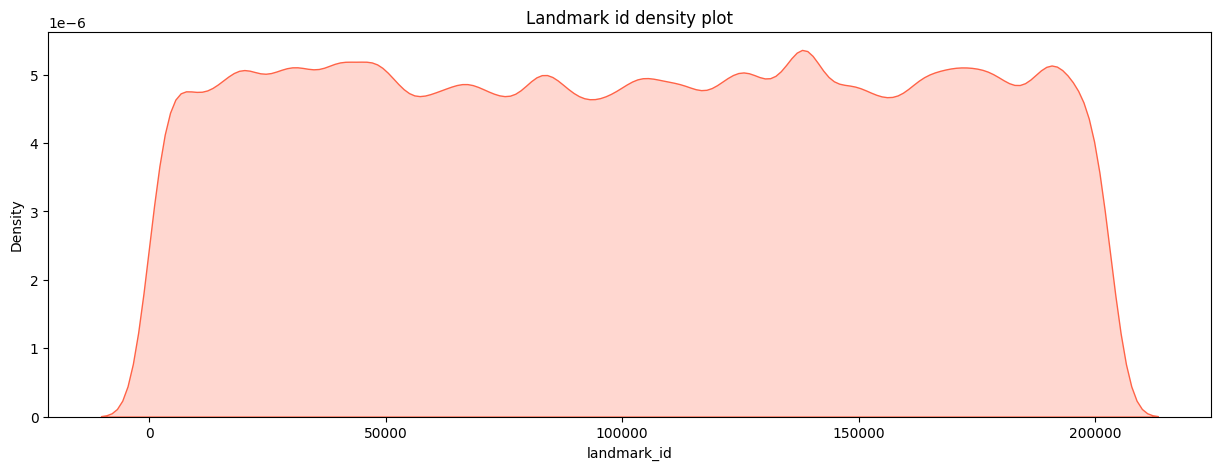

In [14]:
# Landmark Id Density Plot
plt.figure(figsize = (15, 5))
plt.title('Landmark id density plot')
sns.kdeplot(train_df['landmark_id'], color="tomato", shade=True)
plt.show()

/tmp/ipykernel_24/3091605480.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['landmark_id'],color='green', kde=True,bins=200)


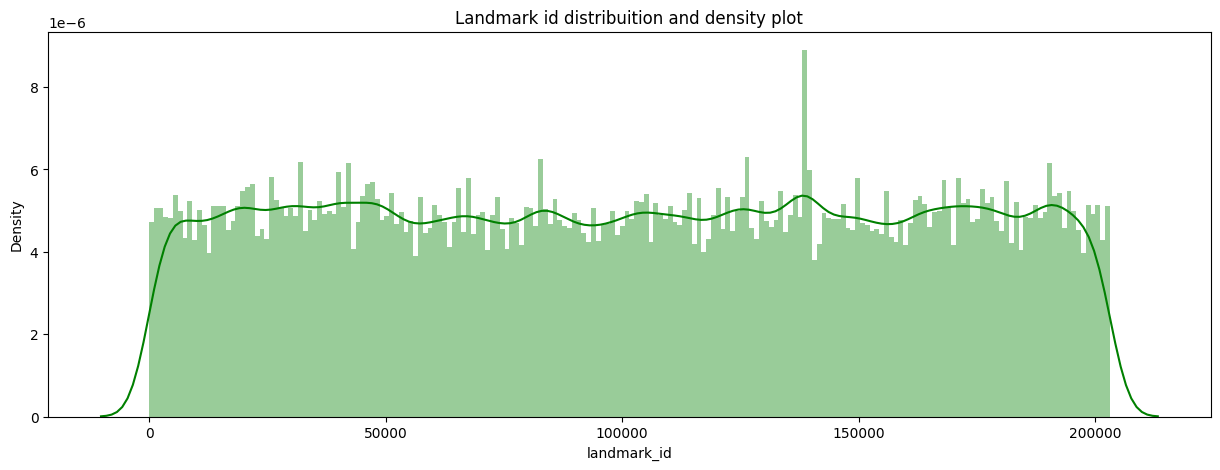

In [15]:
#Landmark id distribuition and density plot
plt.figure(figsize = (15, 5))
plt.title('Landmark id distribuition and density plot')
sns.distplot(train_df['landmark_id'],color='green', kde=True,bins=200)
plt.show()

Text(0.5, 1.0, 'Number of images for each landmark category')

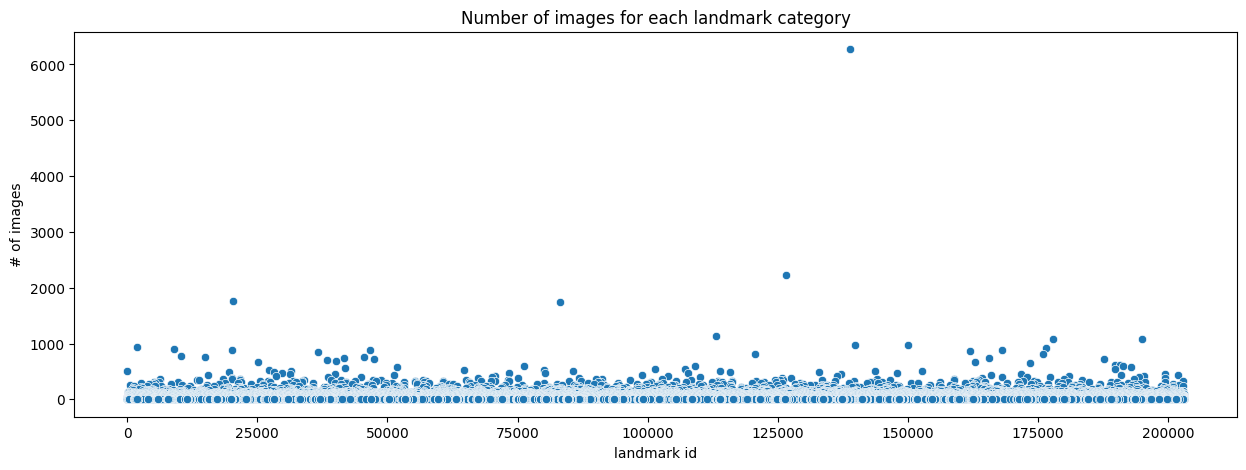

In [16]:
#scatter plot
temp = train_df.landmark_id.value_counts().to_frame()
temp.reset_index(inplace=True)
temp.columns=['landmark_id','count']

plt.figure(figsize=(15,5))
sns.scatterplot(x='landmark_id', y='count', data=temp)
plt.ylabel('# of images')
plt.xlabel('landmark id')
plt.title('Number of images for each landmark category')

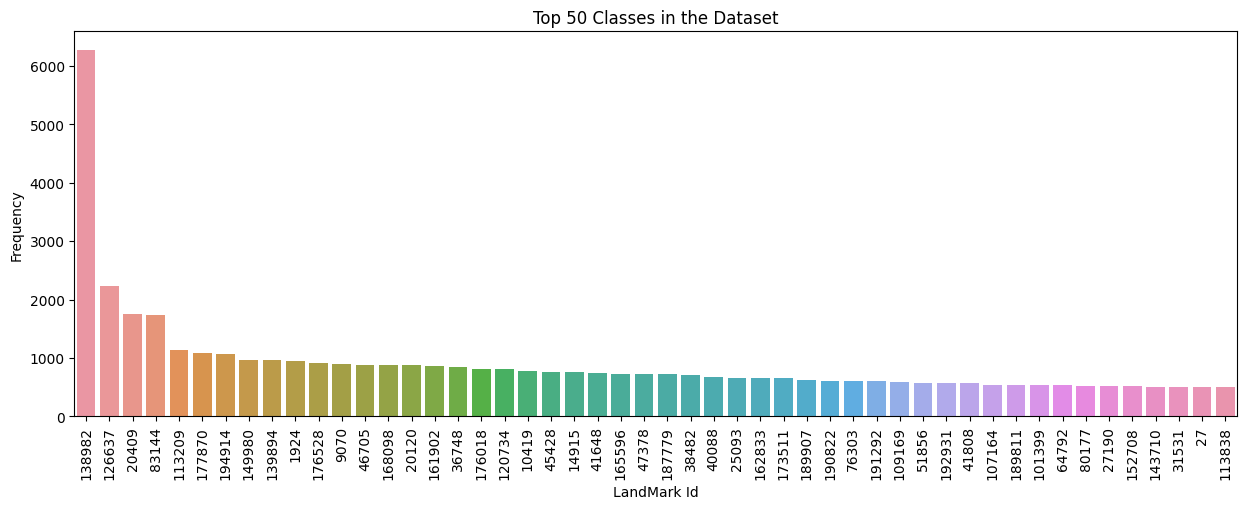

In [17]:
fig = plt.figure(figsize = (15,5))
count = train_df.landmark_id.value_counts().sort_values(ascending=False)[:50]
sns.countplot(x=train_df.landmark_id,order = train_df.landmark_id.value_counts().sort_values(ascending=False).iloc[:50].index)
plt.xticks(rotation = 90)
plt.xlabel("LandMark Id")
plt.ylabel("Frequency")
plt.title("Top 50 Classes in the Dataset")
plt.show()

In [18]:
train_list = glob.glob('../input/landmark-recognition-2020/train/*/*/*/*')

In [19]:
train_list[:5]

['../input/landmark-recognition-2020/train/7/7/7/777fd83f2be84aa9.jpg',
 '../input/landmark-recognition-2020/train/7/7/7/77749d9e47327c2c.jpg',
 '../input/landmark-recognition-2020/train/7/7/7/777854790c50eec9.jpg',
 '../input/landmark-recognition-2020/train/7/7/7/777e7190732764e0.jpg',
 '../input/landmark-recognition-2020/train/7/7/7/777cd9d70fa1916a.jpg']

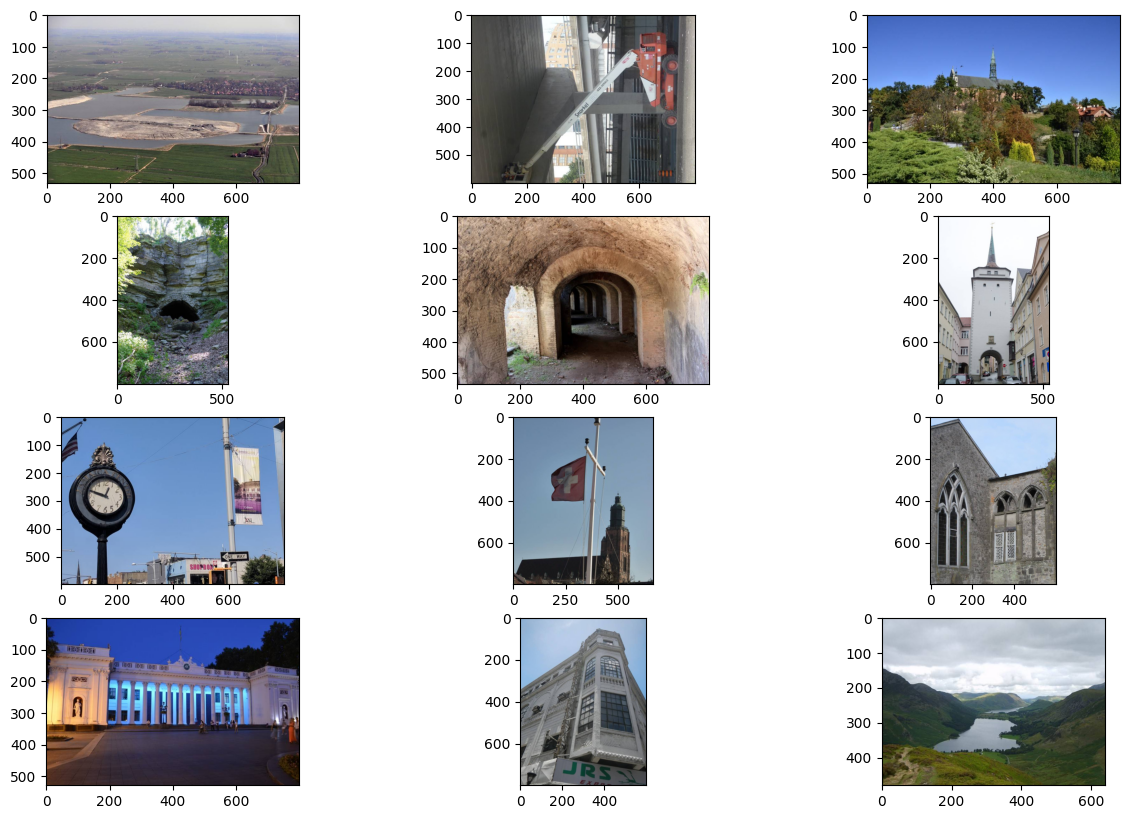

In [20]:
plt.rcParams["axes.grid"] = False
f, axarr = plt.subplots(4, 3, figsize=(15, 10))
curr_row = 0
for i in range(12):
    example = cv2.imread(train_list[i])
    example = example[:,:,::-1]
    col = i%4
    axarr[col, curr_row].imshow(example)
    if col == 3:
        curr_row += 1

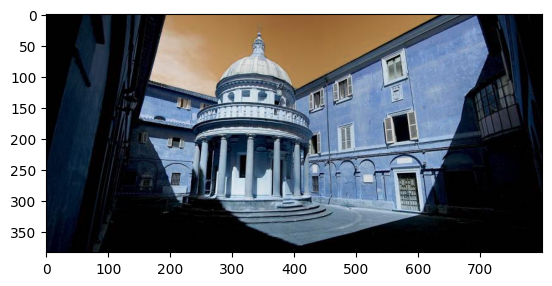

In [21]:
example = cv2.imread(train_list[112])
plt.imshow(example)

In [22]:
train_df["filename"] = train_df.id.str[0]+"/"+train_df.id.str[1]+"/"+train_df.id.str[2]+"/"+train_df.id+".jpg"
train_df["label"] = train_df.landmark_id.astype(str)

In [23]:
train_df.head()

,id,landmark_id,filename,label
0,17660ef415d37059,1,1/7/6/17660ef415d37059.jpg,1
1,92b6290d571448f6,1,9/2/b/92b6290d571448f6.jpg,1
2,cd41bf948edc0340,1,c/d/4/cd41bf948edc0340.jpg,1
3,fb09f1e98c6d2f70,1,f/b/0/fb09f1e98c6d2f70.jpg,1
4,25c9dfc7ea69838d,7,2/5/c/25c9dfc7ea69838d.jpg,7


In [24]:
from collections import Counter
count_val = train_df.landmark_id.values
print(count_val)
print(len(count_val))
count = Counter(count_val).most_common(1000)
print(len(count),count[-1])

[     1      1      1 ... 203092 203092 203092]
1580470
1000 (180646, 142)


In [25]:
# only keep 1000 classes
keep_labels = [i[0] for i in count]
train_keep = train_df[train_df.landmark_id.isin(keep_labels)]

In [26]:
val_rate = 0.2
batch_size = 32

In [27]:
gen = ImageDataGenerator(validation_split=val_rate)

train_gen = gen.flow_from_dataframe(
    train_keep,
    directory="/kaggle/input/landmark-recognition-2020/train/",
    x_col="filename",
    y_col="label",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    subset="training",
    interpolation="nearest",
    validate_filenames=False)
    
val_gen = gen.flow_from_dataframe(
    train_keep,
    directory="/kaggle/input/landmark-recognition-2020/train/",
    x_col="filename",
    y_col="label",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    subset="validation",
    interpolation="nearest",
    validate_filenames=False)

Found 201399 non-validated image filenames belonging to 1000 classes.
Found 50349 non-validated image filenames belonging to 1000 classes.


In [28]:
#model
model = tf.keras.Sequential([
    efn.EfficientNetB2(
        input_shape=(256, 256, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalAveragePooling2D(),
    L.Dense(1000, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['categorical_accuracy']
)

31936256/31936256 [==============================] - 1s 0us/step


In [29]:
# training parameters
epochs = 5 # maximum number of epochs
train_steps = int(len(train_keep)*(1-val_rate))//batch_size
val_steps = int(len(train_keep)*val_rate)//batch_size

# model_checkpoint = ModelCheckpoint("model_efnB3.h5", save_best_only=True, verbose=1)

In [30]:
history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=epochs,validation_data=val_gen, validation_steps=val_steps)
# history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs,validation_data=val_gen, validation_steps=val_steps, callbacks=[model_checkpoint])

# model.save("model.h5")

Epoch 1/5


2023-05-08 02:27:45.318195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6293/6293 [==============================] - 2989s 466ms/step - loss: 1.7203 - categorical_accuracy: 0.6209 - val_loss: 20.5536 - val_categorical_accuracy: 0.0041
Epoch 2/5
6293/6293 [==============================] - 2836s 451ms/step - loss: 0.6959 - categorical_accuracy: 0.8188 - val_loss: 21.4284 - val_categorical_accuracy: 0.0037
Epoch 3/5
6293/6293 [==============================] - 2908s 462ms/step - loss: 0.4565 - categorical_accuracy: 0.8749 - val_loss: 22.0836 - val_categorical_accuracy: 0.0039
Epoch 4/5
6293/6293 [==============================] - 2814s 447ms/step - loss: 0.3327 - categorical_accuracy: 0.9052 - val_loss: 22.5345 - val_categorical_accuracy: 0.0052
Epoch 5/5
6293/6293 [==============================] - 2881s 458ms/step - loss: 0.2543 - categorical_accuracy: 0.9261 - val_loss: 22.3390 - val_categorical_accuracy: 0.0049


<function matplotlib.pyplot.show(close=None, block=None)>

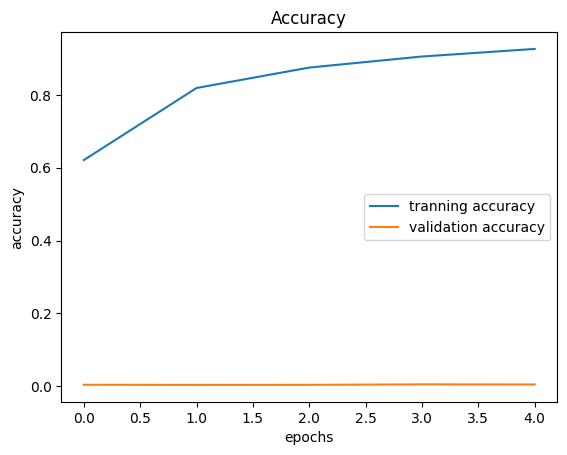

In [31]:
#accuracy
plt.figure(0)
plt.plot(history.history['categorical_accuracy'],label='tranning accuracy')
plt.plot(history.history['val_categorical_accuracy'],label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

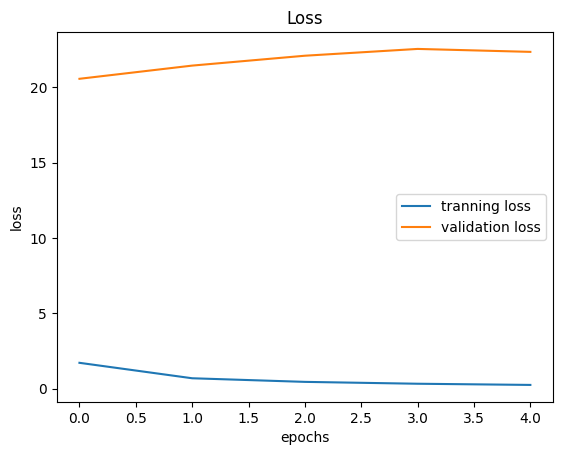

In [32]:
#Loss

plt.plot(history.history['loss'],label='tranning loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show

In [33]:
sub = pd.read_csv("/kaggle/input/landmark-recognition-2020/sample_submission.csv")
sub["filename"] = sub.id.str[0]+"/"+sub.id.str[1]+"/"+sub.id.str[2]+"/"+sub.id+".jpg"
sub

,id,landmarks,filename
0,00084cdf8f600d00,137790 0.1,0/0/0/00084cdf8f600d00.jpg
1,000b15b043eb8cf0,137790 0.1,0/0/0/000b15b043eb8cf0.jpg
2,0011a52f9b948fd2,137790 0.1,0/0/1/0011a52f9b948fd2.jpg
3,00141b8a5a729084,137790 0.1,0/0/1/00141b8a5a729084.jpg
4,0018aa4b92532b77,137790 0.1,0/0/1/0018aa4b92532b77.jpg
...,...,...,...
10340,ffc41ddbcf63289b,137790 0.1,f/f/c/ffc41ddbcf63289b.jpg
10341,ffd4c19b7732cbe9,137790 0.1,f/f/d/ffd4c19b7732cbe9.jpg
10342,ffee2cac79a173d6,137790 0.1,f/f/e/ffee2cac79a173d6.jpg
10343,ffef459d5dc6b981,137790 0.1,f/f/e/ffef459d5dc6b981.jpg


In [34]:
test_gen = ImageDataGenerator().flow_from_dataframe(
    sub,
    directory="/kaggle/input/landmark-recognition-2020/test/",
    x_col="filename",
    y_col=None,
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode=None,
    batch_size=1,
    shuffle=True,
    subset=None,
    interpolation="nearest",
    validate_filenames=False)


Found 10345 non-validated image filenames.


In [35]:
y_pred_one_hot = model.predict_generator(test_gen, verbose=1, steps=len(sub))

/tmp/ipykernel_24/534823022.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_one_hot = model.predict_generator(test_gen, verbose=1, steps=len(sub))


10345/10345 [==============================] - 188s 18ms/step


In [36]:
y_pred_one_hot2 = model.predict(test_gen, verbose=1, steps=len(sub))

10345/10345 [==============================] - 157s 15ms/step


In [37]:
y_pred = np.argmax(y_pred_one_hot2, axis=-1)
y_prob = np.max(y_pred_one_hot2, axis=-1)
print(y_pred.shape, y_prob.shape)

(10345,) (10345,)


In [38]:
y_uniq = np.unique(train_keep.landmark_id.values)

y_pred = [y_uniq[Y] for Y in y_pred]

In [39]:
for i in range(len(sub)):
    sub.loc[i, "landmarks"] = str(y_pred[i])+" "+str(y_prob[i])
sub = sub.drop(columns="filename")
sub.to_csv("submission.csv", index=False)
sub

,id,landmarks
0,00084cdf8f600d00,180646 0.3210732
1,000b15b043eb8cf0,82233 0.49843872
2,0011a52f9b948fd2,80249 0.97029895
3,00141b8a5a729084,19455 0.8410526
4,0018aa4b92532b77,50484 0.4347996
...,...,...
10340,ffc41ddbcf63289b,78791 0.44783255
10341,ffd4c19b7732cbe9,105337 0.43241835
10342,ffee2cac79a173d6,151942 0.37112737
10343,ffef459d5dc6b981,200858 0.5152419
